In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import matplotlib.pyplot as plt
!pip install pmdarima
from pmdarima import auto_arima
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

In [2]:
data=pd.read_csv("C:\\Users\\aashr\\Downloads\\All_tickets.csv",index_col='Date',parse_dates=True)

Tickets    int64
dtype: object

In [4]:
warnings.filterwarnings("ignore")

In [5]:
data.index.freq='MS'

In [6]:
data =data.dropna()

In [7]:
def arima_sarima(data):
    rmse_error=0
    result = seasonal_decompose(data['Tickets'],model ='multiplicative',period=1)
    stepwise_fit = auto_arima(data['Tickets'], start_p = 1, start_q = 1,max_p = 3, max_q = 3, m = 12,
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True) 
    train = data.iloc[:len(data)-12]
    test = data.iloc[len(data)-12:] 
    model = SARIMAX(train['Tickets'], 
                order = (1,0,0), 
                seasonal_order =(0, 1, 0, 12))
    result = model.fit()
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = result.predict(start, end,typ = 'levels').rename("Predictions")
    rmse_error=rmse(test["Tickets"], predictions)
    mse=mean_squared_error(test["Tickets"], predictions)
    return rmse_error

In [8]:
def lstm(data):
    results = seasonal_decompose(data['Tickets'])
    train = data.iloc[:48]
    test = data.iloc[48:]
    test1=test.copy()
    scaler = MinMaxScaler()
    scaler.fit(train)
    scaled_train = scaler.transform(train)
    scaled_test = scaler.transform(test)
    scaled_train[:10]
    n_input = 3
    n_features = 1
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
    X,y = generator[0]
    n_input = 12
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(generator,epochs=50)
    loss_per_epoch = model.history.history['loss']
    last_train_batch = scaled_train[-12:]
    last_train_batch = last_train_batch.reshape((1, n_input, n_features))
    model.predict(last_train_batch)
    test_predictions = []

    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))
    for i in range(len(test)):
        current_pred = model.predict(current_batch)[0]
        test_predictions.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    true_predictions = scaler.inverse_transform(test_predictions)
    test['Predictions'] = true_predictions
    rmse=sqrt(mean_squared_error(test1['Tickets'],test['Predictions']))
    return rmse

In [9]:
x=arima_sarima(data)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=674.783, Time=0.89 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=675.030, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=673.406, Time=0.73 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=674.513, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=695.488, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=672.431, Time=0.08 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=673.396, Time=0.35 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=675.413, Time=0.29 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=673.781, Time=0.20 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=673.686, Time=0.36 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=673.272, Time=0.16 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=675.610, Time=0.50 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=678.958, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 4.225 seconds


In [12]:
y=lstm(data)

Epoch 1/50
36/36 [==============================] - 6s 13ms/step - loss: 0.0941
Epoch 2/50
36/36 [==============================] - 1s 13ms/step - loss: 0.0570
Epoch 3/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0509
Epoch 4/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0485
Epoch 5/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0472
Epoch 6/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0486
Epoch 7/50
36/36 [==============================] - 1s 13ms/step - loss: 0.0491
Epoch 8/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0453
Epoch 9/50
36/36 [==============================] - 1s 14ms/step - loss: 0.0421
Epoch 10/50
36/36 [==============================] - 1s 14ms/step - loss: 0.0410
Epoch 11/50
36/36 [==============================] - 1s 13ms/step - loss: 0.0431
Epoch 12/50
36/36 [==============================] - 1s 13ms/step - loss: 0.0450
Epoch 13/50
36/36 [==================

rmse of arima-sarima prediction is: 164.15575968167173
rmse of lstm prediction is: 2866.836873498728
the best model fit is arima-sarima:


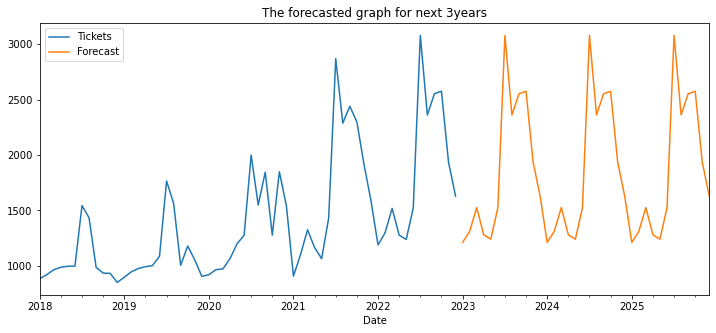

In [13]:
print('rmse of arima-sarima prediction is:',x)
print('rmse of lstm prediction is:',y)
if(x<y):
    print('the best model fit is arima-sarima:')
    model = model = SARIMAX(data['Tickets'], 
                        order = (1, 0,0), 
                        seasonal_order =(0, 1, 0, 12))
    result = model.fit()
    forecast = result.predict(start = len(data), 
                          end = (len(data)-1) + 3 * 12, 
                          typ = 'levels').rename('Forecast')
    data['Tickets'].plot(figsize = (12, 5), legend = True)
    plt.title('The forecasted graph for next 3years')
    forecast.plot(legend = True)